# Programming Assignment: A Pneumonia Diagnostic Assistant



<a name='0'></a>
## Imports

In [1]:
import sys
import warnings

# Redirect stderr to a black hole to catch other potential messages
class BlackHole:
    def write(self, message):
        pass
    def flush(self):
        pass
sys.stderr = BlackHole()

# Ignore Python-level UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import os

import lightning.pytorch as pl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from lightning.pytorch.callbacks import EarlyStopping
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torchvision import datasets, transforms
from torchvision import models as tv_models

torch.set_float32_matmul_precision('medium')

In [3]:
import matplotlib.pyplot as plt

import helper_utils
import unittests

<a name='1'></a>
## 1 - Chest X-Ray Images



<a name='1-1'></a>
### 1.1 - Dataset Preparation


In [4]:
data_dir = "./chest_xray/"

<a name='1-2'></a>
### 1.2 - Data Structure

The data is organized into `train` and `val` directories, with subdirectories for each of the three classes. 

```
./chest_xray/
│
├── train/
│   ├── NORMAL/
│   │   ├── IM-0001-0001.jpeg
│   │   └── ...
│   │
│   ├── BACTERIAL_PNEUMONIA/
│   │   ├── person1_bacteria_1.jpeg
│   │   └── ...
│   │
│   └── VIRAL_PNEUMONIA/
│       ├── person140_virus_284.jpeg
│       └── ...
│
└── val/
    ├── NORMAL/
    │   ├── IM-0001-0001.jpeg
    │   └── ...
    │
    ├── BACTERIAL_PNEUMONIA/
    │   ├── person1946_bacteria_4874.jpeg
    │   └── ...
    │
    └── VIRAL_PNEUMONIA/
        ├── person16_virus_44.jpeg
        └── ...
```



In [5]:
helper_utils.display_dataset_count(data_dir)

--- Train Set ---
  - BACTERIAL_PNEUMONIA      : 1338 images
  - NORMAL                   : 1338 images
  - VIRAL_PNEUMONIA          : 1338 images
——————————————————————————————————————————————————
  Total:                      4014 images

--- Val Set ---
  - BACTERIAL_PNEUMONIA      : 148 images
  - NORMAL                   : 148 images
  - VIRAL_PNEUMONIA          : 148 images
——————————————————————————————————————————————————
  Total:                       444 images



<a name='1-3'></a>
### 1.3 - The Visual Challenge: Differentiating Pneumonia Types



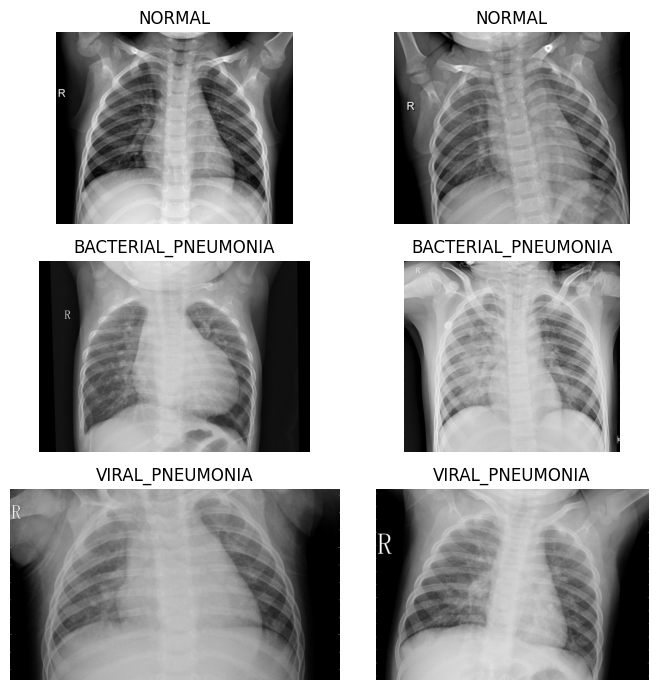

In [6]:
# Display a grid of random images from the training set to visualize the data.
helper_utils.display_random_images(data_dir + "train")

<a name='2'></a>
## 2 - Building the `DataModule`


### 2.1 - Utilities for the `DataModule`



In [7]:
# Define the series of transformations to be applied to the training images.
TRAIN_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # Perform a random affine transformation: shifting and scaling the image.
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    # Normalize the tensor image with a precalculated mean and standard deviation
    # of this dataset.
    transforms.Normalize([0.482, 0.482, 0.482], [0.222, 0.222, 0.222])
])

# Define the transformations for the validation images.
VAL_TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize the tensor image with a precalculated mean and standard deviation
    # of this dataset.
    transforms.Normalize([0.482, 0.482, 0.482], [0.222, 0.222, 0.222])
])

* `create_datasets(…)`: This function takes file paths and transforms as input and returns the initialized training and validation `ImageFolder` datasets.

In [8]:
def create_datasets(train_path, val_path, train_transform, val_transform):
    """
    Creates and returns the necessary datasets for training and validation.

    Args:
        train_path (str): The file path to the training images.
        val_path (str): The file path to the validation images.
        train_transform (callable): Transformations to apply to the training data.
        val_transform (callable): Transformations to apply to the validation data.

    Returns:
        A tuple containing the train_dataset and val_dataset.
    """
    # Create the training and validation datasets from the image folders.
    train_dataset = datasets.ImageFolder(train_path, train_transform)
    val_dataset = datasets.ImageFolder(val_path, val_transform)

    return train_dataset, val_dataset

* `load_dataloader(…)`: This function takes the datasets and other parameters to create and return *either* a training *or* validation `DataLoader`.

In [9]:
def load_dataloader(train_dataset, val_dataset, batch_size, is_train_loader):
    """
    Creates and returns either a training or validation DataLoader.

   Args:
        train_dataset (Dataset): The dataset for the training loader.
        val_dataset (Dataset): The dataset for the validation loader.
        batch_size (int): The number of samples per batch to load.
        is_train_loader (bool): A flag to determine which loader to create.
                                If True, creates the training loader.
                                If False, creates the validation loader.

    Returns:
        DataLoader: The configured PyTorch DataLoader.
    """
    # Check the flag to determine whether to create a training or validation loader.
    if is_train_loader==True:
        # Create the training DataLoader.
        loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )
    
    else:
        # Create the validation DataLoader.
        loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )
        
    return loader

<a name='2-2'></a>
### 2.2 - Assembling the `ChestXRayDataModule`



In [ ]:


class ChestXRayDataModule(pl.LightningDataModule):
    """
    A LightningDataModule encapsulates all the steps involved in preparing data
    for a PyTorch model.
    """

    def __init__(self, data_dir, batch_size=64):
        super().__init__()
        
       
        
        # Store the constructor arguments as instance attributes.
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        # Assign the globally defined transformations to this instance.
        # (Assuming these are defined elsewhere in your notebook/script)
        self.train_transform = TRAIN_TRANSFORM
        self.val_transform = VAL_TRANSFORM
        
       
        
        # DO NOT REMOVE THESE PLACEHOLDERS
        self.train_dataset = None
        self.val_dataset = None

    def setup(self, stage=None):
        # Construct paths
        train_path = os.path.join(self.data_dir, "train")
        val_path = os.path.join(self.data_dir, "val")
        
       
        
        # Initialize datasets using the helper function
        self.train_dataset, self.val_dataset = create_datasets(
            train_path,
            val_path,
            self.train_transform,
            self.val_transform,
        )
            
       

    def train_dataloader(self):
        """Returns the DataLoader for the training set."""
        
        
        
        train_loader = load_dataloader(
            self.train_dataset,
            self.val_dataset,
            self.batch_size,
            is_train_loader=True,
        )
        
        
        
        return train_loader

    def val_dataloader(self):
        """Returns the DataLoader for the validation set."""
        
        
        
        val_loader = load_dataloader(
            self.train_dataset,
            self.val_dataset,
            self.batch_size,
            is_train_loader=False,
        )
        
        
        
        return val_loader

In [23]:
# Instantiate the DataModule for verification.
dm_verify = ChestXRayDataModule(data_dir=data_dir, batch_size=8)
# Set up the datasets.
dm_verify.setup()
train_loader_verify = dm_verify.train_dataloader()
val_loader_verify = dm_verify.val_dataloader()

# --- Verify the Training Set ---
print("--- Training Set ---")
print(f"Total samples in the training dataset:    {len(dm_verify.train_dataset)}")
print(f"DataLoader batch size:                    {train_loader_verify.batch_size}")
print(f"DataLoader length (number of batches):    {len(train_loader_verify)}")

# --- Verify the Validation Set ---
print("\n--- Validation Set ---")
print(f"Total samples in the validation dataset:  {len(dm_verify.val_dataset)}")
print(f"DataLoader batch size:                    {val_loader_verify.batch_size}")
print(f"DataLoader length (number of batches):    {len(val_loader_verify)}")

--- Training Set ---
Total samples in the training dataset:    4014
DataLoader batch size:                    8
DataLoader length (number of batches):    502

--- Validation Set ---
Total samples in the validation dataset:  444
DataLoader batch size:                    8
DataLoader length (number of batches):    56


<a name='3'></a>
## 3 - Building the `LightningModule`



<a name='3-1'></a>
### 3.1 - Utilities for the `LightningModule`

The helper functions below are designed to handle model initialization and optimizer configuration.
* `load_resnet18(…)`: This function initializes a ResNet-18 model and prepares it for transfer learning. 

In [25]:
def load_resnet18(num_classes, weights_path):
    """
    Initializes a ResNet-18 model, loads weights, and sets it up
    for transfer learning (feature extraction).

    Args:
        num_classes (int): The number of output classes for the new classifier head.
        weights_path (str): The file path to the saved .pth model weights.

    Returns:
        A PyTorch model (ResNet-18) where all layers are frozen except for
        the final classifier head.
    """
    # Initialize a ResNet-18 model without pre-trained weights.
    model = tv_models.resnet18(weights=None)

    # Replace the classifier head to match the number of classes for the new task.
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load the state dictionary (weights) from the local file.
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)

    # Freeze all the parameters in the model.
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze ONLY the parameters of the new classifier head.
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

* `define_optimizer_and_scheduler(…)`: This function returns the `AdamW` optimizer and a `ReduceLROnPlateau` learning rate scheduler. The scheduler will automatically reduce the learning rate if the validation loss stops improving, which is a common technique for effective training.

In [26]:
def define_optimizer_and_scheduler(model, learning_rate, weight_decay):
    """
    Defines the optimizer and learning rate scheduler for the model.

    Args:
        model (nn.Module): The model for which to configure the optimizer.
                           Its parameters will be passed to the optimizer.
        learning_rate (float): The learning rate for the optimizer.
        weight_decay (float): The weight decay (L2 penalty) for the optimizer.

    Returns:
        A tuple containing the configured optimizer and lr_scheduler.
    """
    # Create the optimizer.
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Create the learning rate scheduler.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2
    )
    
    return optimizer, scheduler

<a name='3-2'></a>
### 3.2 - Assembling the `ChestXRayClassifier`



In [ ]:


class ChestXRayClassifier(pl.LightningModule):
    """A LightningModule that is focused on tracking validation loss and accuracy."""

    def __init__(self, model_weights_path, num_classes=3, learning_rate=1e-3, weight_decay=1e-2):
        """
        Initializes the ChestXRayClassifier module.

        Args:
            model_weights_path (str): The file path to the pre-trained ResNet-18 model weights.
            num_classes (int): The number of classes for classification. Defaults to 3.
            learning_rate (float): The learning rate for the optimizer. Defaults to 1e-3.
            weight_decay (float): The weight decay (L2 penalty) for the optimizer. Defaults to 1e-2.
        """
        super().__init__()
        # Save all __init__ arguments (model_weights_path, num_classes, etc.) to self.hparams
        # For example, you’ll access `num_classes` as `self.hparams.num_classes`
        self.save_hyperparameters()
        
       

        # Call the `load_resnet18` helper function to get the pre-trained model.
        self.model = load_resnet18(
            self.hparams.num_classes,
            self.hparams.model_weights_path
        )
        
        # Define the Cross Entropy loss function.
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Define the accuracy metric using `Accuracy`.
        # Remember to specify the task and the number of classes.
        self.accuracy = Accuracy(
            task="multiclass",
            num_classes=self.hparams.num_classes
        )
        
        

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor of images.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx=None):
        """
        Performs a single training step. Loss calculation is required for backpropagation.

        Args:
        batch (tuple): A tuple containing the input images and their labels.
        batch_idx (int): The index of the current batch. The Lightning Trainer
                         requires this argument, but it's not utilized in this
                         implementation as the logic is the same for all batches.
        """
        
        
        
        # Unpack the batch into images and labels.
        x, y = batch
        # Perform a forward pass to get the model's logits.
        logits = self(x)
        # Calculate the loss by comparing the logits to the true labels.
        loss = self.loss_fn(logits, y)
        
        
        
        return loss

    def validation_step(self, batch, batch_idx=None):
        """
        Performs a single validation step and logs only the loss and accuracy.

        Args:
        batch (tuple): A tuple containing the input images and their labels.
        batch_idx (int): The index of the current batch. The Lightning Trainer
                         requires this argument, but it's not utilized in this
                         implementation as the logic is the same for all batches.
        """
        
        
        
        # Unpack the batch into images and labels.
        x, y = batch
        # Perform a forward pass to get the model's logits.
        logits = self(x)
        # Calculate the loss.
        loss = self.loss_fn(logits, y)
        # Calculate the accuracy.
        acc = self.accuracy(logits, y)
        
       
        
        # Log metrics for this validation epoch and show them in the progress bar.
        self.log_dict({'val_loss': loss, 'val_acc': acc}, prog_bar=True)

    def configure_optimizers(self):
        """Configures the optimizers and learning rate scheduler."""
        
      
        
        # Call the `define_optimizer_and_scheduler` helper function.
        optimizer, scheduler = define_optimizer_and_scheduler(
            self.model,
            self.hparams.learning_rate,
            self.hparams.weight_decay
        )
        
       
        
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

In [28]:
# Instantiate the classifier for verification.
weights_path = helper_utils.setup_dummy_weights()
verify_model = ChestXRayClassifier(model_weights_path=weights_path)

# Get the optimizer and scheduler.
optimizer_config = verify_model.configure_optimizers()
optimizer = optimizer_config["optimizer"]
scheduler = optimizer_config["lr_scheduler"]["scheduler"]

# --- Print the results to verify ---
print("--- LightningModule Components ---")
print(f"Model Architecture: {verify_model.model.__class__.__name__}")
print(f"Classifier Head:    {verify_model.model.fc}")
print(f"Loss Function:      {verify_model.loss_fn.__class__.__name__}")
print(f"Accuracy Metric:    {verify_model.accuracy.__class__.__name__}(num_classes={verify_model.accuracy.num_classes})")
print(f"Optimizer:          {optimizer.__class__.__name__}")
print(f"LR Scheduler:       {scheduler.__class__.__name__}")
# Clean dummy weights
helper_utils.cleanup_dummy_weights()

--- LightningModule Components ---
Model Architecture: ResNet
Classifier Head:    Linear(in_features=512, out_features=3, bias=True)
Loss Function:      CrossEntropyLoss
Accuracy Metric:    MulticlassAccuracy(num_classes=3)
Optimizer:          AdamW
LR Scheduler:       ReduceLROnPlateau


<a name='4'></a>
## 4 - Training the Model



<a name='4-1'></a>
### 4.1 - Configuring Early Stopping

Training a model for too long can lead to overfitting, while stopping too soon can result in an undertrained model. A common technique to find the right balance is **early stopping**.



In [ ]:


def early_stopping(num_epochs, stop_threshold):
    """
    Configures and returns a Lightning EarlyStopping callback.

    Args:
        num_epochs (int): The maximum number of epochs, used to set patience.
        stop_threshold (float): The validation accuracy threshold to stop training.

    Returns:
        EarlyStopping: The configured Lightning callback.
    """
    
    
    
    # Instantiate the EarlyStopping callback.
    stop = EarlyStopping(
        # Specify the metric to monitor as validation accuracy.
        monitor="val_acc",
        
        # Set the value that the monitored metric must reach to stop training.
        stopping_threshold=stop_threshold,
        
        # Set patience to half of the total epochs. Must be an integer.
        patience=int(num_epochs / 2),
        
        # Set the mode to "max" because higher accuracy is better.
        mode="max"
    ) 
    
    
    
    return stop

In [31]:
# Define sample parameters for verification.
num_epochs_verify = 15
stop_threshold_verify = 0.90

# Call the function to create the callback.
verify_callback = early_stopping(num_epochs_verify, stop_threshold_verify)

# --- Print the results to verify ---
print("--- EarlyStopping Configuration ---")
print(f"Metric to Monitor:     {verify_callback.monitor}")
print(f"Stopping Threshold:    {verify_callback.stopping_threshold}")
print(f"Patience:              {verify_callback.patience}")
print(f"Mode:                  {verify_callback.mode}")

--- EarlyStopping Configuration ---
Metric to Monitor:     val_acc
Stopping Threshold:    0.9
Patience:              7
Mode:                  max


<a name='4-2'></a>
### 4.2 - Configuring the Trainer





In [ ]:


def run_training(model, data_module, num_epochs, callback, progress_bar=True, dry_run=False):
    """
    Configures and runs a Lightning mixed-precision training process.

    Args:
        model (pl.LightningModule): The model to be trained.
        data_module (pl.LightningDataModule): The data module that provides the datasets.
        num_epochs (int): The maximum number of epochs for training.
        callback (pl.Callback): A callback, such as for early stopping.
        progress_bar (bool): If True, shows the training progress bar. Defaults to True.
        dry_run (bool): If True, runs a quick single batch "dry run" to test the code.
                        Defaults to False.

    Returns:
        A tuple containing:
            - pl.Trainer: The trainer instance after fitting is complete.
            - pl.LightningModule: The trained model with updated weights.
    """
    
    
    
    # Instantiate the PyTorch Lightning Trainer with specific configurations.
    trainer = pl.Trainer(
        # Set the maximum number of training epochs.
        max_epochs=num_epochs,
        
        # Automatically select the best hardware accelerator (GPU, CPU).
        accelerator="auto", 
        # Use a single device.
        devices=1, 
        
        # Enable 16-bit mixed-precision training to speed up computation.
        precision="16-mixed",
        # Add callback
        callbacks=[callback],
        
    
        
        # Disable the default logger.
        logger=False,
        # Show the training progress bar.
        enable_progress_bar=progress_bar,
        # Disable the model summary printout
        enable_model_summary=False,
        # Disable automatic model checkpointing.
        enable_checkpointing=False,
        # fast_dev_run flag for test runs.
        fast_dev_run=dry_run
    )
    
    
    
    # Run the training process.
    trainer.fit(model, data_module)
    
    
    
    return trainer, model

In [34]:
# Set up the components for verification run.
verify_dm = ChestXRayDataModule(data_dir=data_dir, batch_size=2)
weights_path = helper_utils.setup_dummy_weights()
verify_model = ChestXRayClassifier(model_weights_path=weights_path)
num_epochs=1
verify_callback = early_stopping(num_epochs=num_epochs, stop_threshold=0.99)

# Call the run_training function with dry_run=True.
print("--- Verifying Training Run (Dry Run) ---")
run_training(
    model=verify_model, 
    data_module=verify_dm, 
    num_epochs=num_epochs, 
    callback=verify_callback,
    dry_run=True
)

print("The Trainer configured and ran a single batch without errors.")
# Clean dummy weights
helper_utils.cleanup_dummy_weights()

--- Verifying Training Run (Dry Run) ---


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

The Trainer configured and ran a single batch without errors.


<a name='4-3'></a>
### 4.3 - Training Your Diagnostic Assistant



In [36]:
# Define the file path for the pre-trained model weights.
pretrained_weights = "./resnet18_chest_xray_classifier_weights.pth"

In [37]:
# EDITABLE CELL

# Set the maximum number of training cycles (epochs).
training_epochs = 10

# Define the validation accuracy threshold to stop training once reached.
target_accuracy = 0.85

In [38]:
# Create the EarlyStopping callback by calling your function with the defined hyperparameters.
early_stopping_callback = early_stopping(training_epochs, target_accuracy)

In [39]:
# Set the random seed to ensure the experiment is reproducible.
pl.seed_everything(15)

# Instantiate the DataModule to handle data loading and transformations.
dm = ChestXRayDataModule(data_dir)
dm.setup()

# Instantiate the LightningModule, passing in the path to the pre-trained weights.
model = ChestXRayClassifier(model_weights_path=pretrained_weights)

# Call the training function with all the components to start the training process.
trained_trainer, trained_model = run_training(
    model, dm, training_epochs, early_stopping_callback
)

# Print a message to confirm that the training has finished.
print("\n--- Training Complete ---")

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


--- Training Complete ---


In [40]:
# Get the final metrics from the trainer object
final_metrics = trained_trainer.callback_metrics

# Extract the validation accuracy and convert it to a number
final_val_acc = final_metrics["val_acc"].item()

# Print the final validation accuracy
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Validation Accuracy: 0.8514


<a name='5'></a>
## 5 - Evaluating Model Performance


<a name='5-1'></a>
### 5.1 - Confusion Matrix and Per-Class Accuracy



Evaluating Model:   0%|          | 0/7 [00:00<?, ?it/s]

--- Per-Class Accuracy Report ---
  - Accuracy for class 'BACTERIAL_PNEUMONIA': 0.9392
  - Accuracy for class 'NORMAL': 0.8243
  - Accuracy for class 'VIRAL_PNEUMONIA': 0.7905



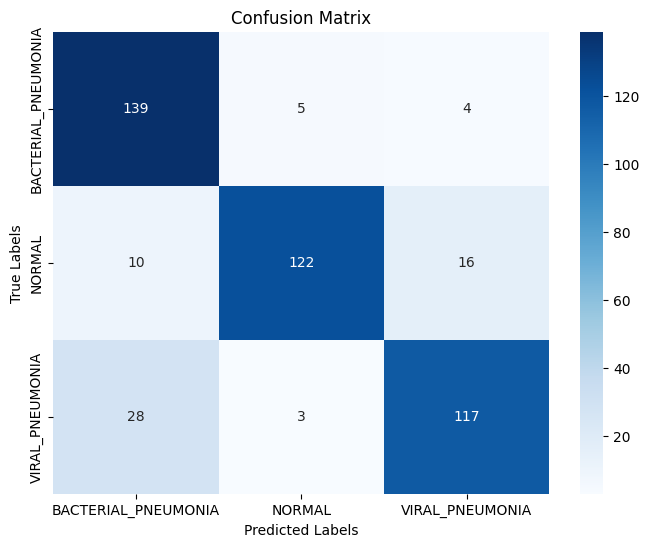

In [41]:
# Evaluate the trained model to display a per-class accuracy report and a confusion matrix.
helper_utils.per_class_acc_and_conf_matrix(trained_model, dm)

<a name='5-2'></a>
### 5.2 - Visualizing Predictions



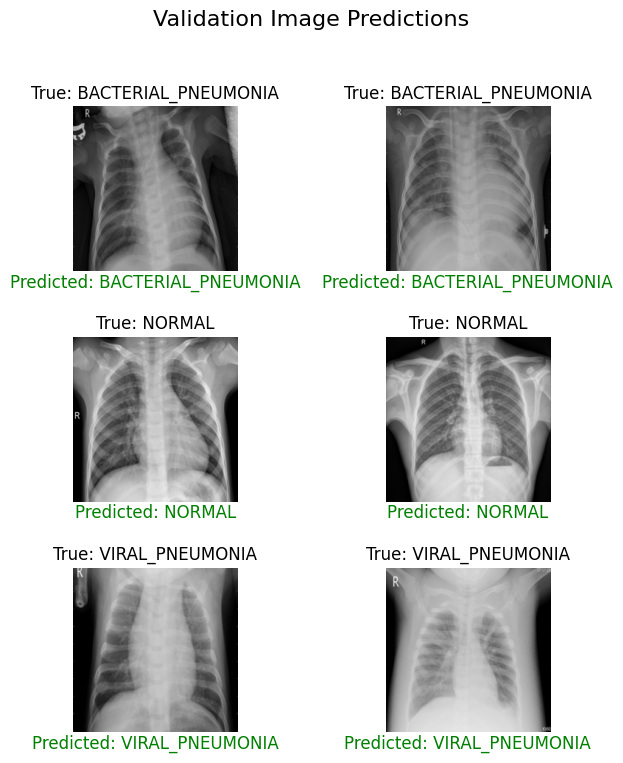

In [42]:
helper_utils.display_random_predictions(trained_model, dm)

<a name='5-3'></a>
### 5.3 - A True Test

Now, for a true test of the model’s predictions. Some images were removed from the original dataset and saved as a truly unseen group. This means the model has never had any exposure to these images during training or validation.

These images are available at the following paths:

* **BACTERIAL_PNEUMONIA**
    * "./unseen/BACTERIAL_PNEUMONIA/person296_bacteria_1394.jpeg" 
    * "./unseen/BACTERIAL_PNEUMONIA/person441_bacteria_1916.jpeg" 
    * "./unseen/BACTERIAL_PNEUMONIA/person564_bacteria_2342.jpeg" 
* **NORMAL**
    * "./unseen/NORMAL/IM-0353-0001.jpeg" 
    * "./unseen/NORMAL/IM-0633-0001.jpeg" 
    * "./unseen/NORMAL/NORMAL2-IM-0866-0001.jpeg" 
* **VIRAL_PNEUMONIA**
    * "./unseen/VIRAL_PNEUMONIA/person1369_virus_2356.jpeg" 
    * "./unseen/VIRAL_PNEUMONIA/person1465_virus_2537.jpeg" 
    * "./unseen/VIRAL_PNEUMONIA/person1537_virus_2674.jpeg" 

Using the `display_prediction` function to see how well the trained model performs on these images.



In [43]:
# EDITABLE CELL

# Define the file path for the unseen image to be predicted.
image_path = "./unseen/BACTERIAL_PNEUMONIA/person296_bacteria_1394.jpeg"

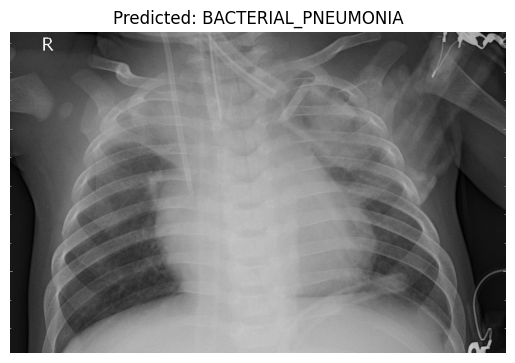

In [44]:
# Use the display_prediction function to show the image and its predicted class.
helper_utils.display_prediction(trained_model, dm, image_path)